In [1]:
# ==== Cell 1: Basic setup (imports) ====

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

In [2]:
# View plots in Jupyter
# %matplotlib inline


# ==== Cell 2: Load data ====

# File path is based on the current session
csv_path = "data/combined_telemetry_3k.csv"

df = pd.read_csv(csv_path)

print("Data shape:", df.shape)
print("Column list:")
print(df.columns.tolist())

Data shape: (3000, 23)
Column list:
['patient_id', 'timestamp', 'hr_bpm_real', 'temp_c_skin_real', 'battery_pct_real', 'hr_bpm', 'temp_c_skin', 'battery_pct', 'is_charging', 'chargeRateC', 'load_mA', 'tempC', 'coilOffsetDeg', 'factorMisalign', 'factorTemp', 'factorRate', 'factorLoad', 'rssi_dBm', 'packetLossPct', 'status', 'anomaly_type', 'row_id', 'label_anomaly']


In [3]:
# ==== Cell 3: Simple EDA (check status and anomaly ratios) ====

print("Distribution of status values:")
print(df["status"].value_counts())

print("\nDistribution of label_anomaly:")
print(df["label_anomaly"].value_counts())

# Also check the proportion of samples for each status
print("\nStatus ratio (%):")
print(df["status"].value_counts(normalize=True) * 100)


Distribution of status values:
status
SAFE      2400
UNSAFE     339
WARN       261
Name: count, dtype: int64

Distribution of label_anomaly:
label_anomaly
0    2400
1     600
Name: count, dtype: int64

Status ratio (%):
status
SAFE      80.0
UNSAFE    11.3
WARN       8.7
Name: proportion, dtype: float64


In [4]:
# ==== Cell 4: Select features (X) and target (y) ====

# Four parameters you want to use as the core of the simulator
feature_cols = ["coilOffsetDeg", "chargeRateC", "tempC", "load_mA"]

X = df[feature_cols].copy()
y_text = df["status"].copy()   # SAFE / WARN / UNSAFE (string)

print("X samples:")
print(X.head())

print("\nstatus (y) samples:")
print(y_text.head())


X samples:
   coilOffsetDeg  chargeRateC      tempC    load_mA
0              7     1.760114  39.359707  21.837512
1              9    -0.050000  42.528158  10.000000
2              6    -0.233372  37.818807  46.674381
3             12    -0.186600  37.813161  37.320010
4             19     1.933084  38.906347  75.079584

status (y) samples:
0      SAFE
1    UNSAFE
2      SAFE
3      SAFE
4      WARN
Name: status, dtype: object


In [5]:
# ==== Cell 5: Encode target (status) labels ====

# Convert string status values into numeric labels like 0, 1, 2
le = LabelEncoder()
y = le.fit_transform(y_text)

print("Label mapping (class_index -> status text):")
for idx, cls in enumerate(le.classes_):
    print(f"{idx} -> {cls}")

# Example: it might print something like 0 -> SAFE, 1 -> UNSAFE, 2 -> WARN

Label mapping (class_index -> status text):
0 -> SAFE
1 -> UNSAFE
2 -> WARN


In [6]:
# ==== Cell 6: Train / Test split ====

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y  # preserve class proportions
)

print("Train size:", X_train.shape, "Test size:", X_test.shape)

Train size: (2400, 4) Test size: (600, 4)


In [7]:
# ==== Cell 7: Simple classification model (Logistic Regression) ====

# Build a single pipeline with a scaler + logistic regression
clf = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        ("logreg", LogisticRegression(max_iter=1000, multi_class="auto"))
    ]
)

clf.fit(X_train, y_train)

print("Train accuracy:", clf.score(X_train, y_train))
print("Test  accuracy:", clf.score(X_test, y_test))

Train accuracy: 0.95125
Test  accuracy: 0.9483333333333334


c:\Users\jjh95\Desktop\Assignment\SENG8100\Project\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


=== Classification Report ===
              precision    recall  f1-score   support

        SAFE       0.96      0.97      0.97       480
      UNSAFE       1.00      1.00      1.00        68
        WARN       0.71      0.67      0.69        52

    accuracy                           0.95       600
   macro avg       0.89      0.88      0.89       600
weighted avg       0.95      0.95      0.95       600



<Figure size 500x500 with 0 Axes>

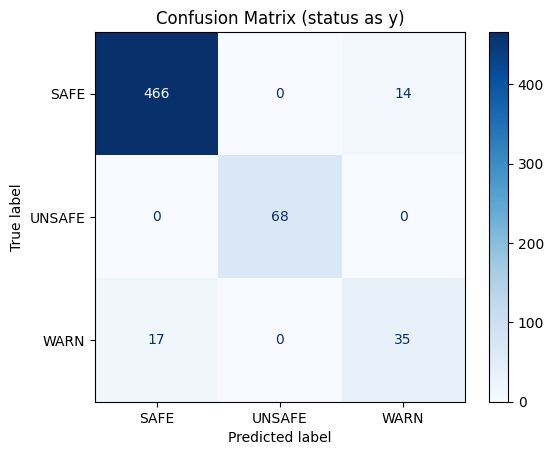

In [8]:
# ==== Cell 8: Evaluation (classification_report, confusion matrix) ====

y_pred = clf.predict(X_test)

print("=== Classification Report ===")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)

plt.figure(figsize=(5, 5))
disp.plot(values_format="d", cmap="Blues")
plt.title("Confusion Matrix (status as y)")
plt.show()

In [9]:
# ==== Cell 9: Predict status for a single example point ====
# (Pattern you can use later when connecting to the What-If simulator UI)

# Example: misalignment 15 degrees, ChargeRate 1.2C, temperature 39°C, load 40mA
example_point = pd.DataFrame(
    {
        "coilOffsetDeg": [15.0],
        "chargeRateC": [1.2],
        "tempC": [39.0],
        "load_mA": [40.0],
    }
)

proba = clf.predict_proba(example_point)[0]
pred_label = clf.predict(example_point)[0]
pred_status = le.inverse_transform([pred_label])[0]

print("Input example:", example_point.iloc[0].to_dict())
print("\nPredicted status:", pred_status)
print("Class probabilities (order: ", list(le.classes_), ")")
print(proba)


Input example: {'coilOffsetDeg': 15.0, 'chargeRateC': 1.2, 'tempC': 39.0, 'load_mA': 40.0}

Predicted status: SAFE
Class probabilities (order:  ['SAFE', 'UNSAFE', 'WARN'] )
[0.63519791 0.00159209 0.36321   ]


In [10]:
# ==== Cell 10: Define risk target (based on label_anomaly) ====

# Input features: the 4 parameters you want to use in the simulator
feature_cols = ["coilOffsetDeg", "chargeRateC", "tempC", "load_mA"]

X = df[feature_cols].copy()

# Risk target:
# If label_anomaly = 1, treat it as an abnormal (UNSAFE/WARN) state,
# and use the "probability of being abnormal" as the risk
y = df["label_anomaly"].astype(int)

print("X samples:")
print(X.head())
print("\nlabel_anomaly distribution:")
print(y.value_counts(), "\nRatio (%):")
print(y.value_counts(normalize=True) * 100)


X samples:
   coilOffsetDeg  chargeRateC      tempC    load_mA
0              7     1.760114  39.359707  21.837512
1              9    -0.050000  42.528158  10.000000
2              6    -0.233372  37.818807  46.674381
3             12    -0.186600  37.813161  37.320010
4             19     1.933084  38.906347  75.079584

label_anomaly distribution:
label_anomaly
0    2400
1     600
Name: count, dtype: int64 
Ratio (%):
label_anomaly
0    80.0
1    20.0
Name: proportion, dtype: float64


In [11]:
# ==== Cell 11: Train / Test split ====

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y  # preserve normal/abnormal ratio
)

X_train.shape, X_test.shape

((2400, 4), (600, 4))

In [12]:
# ==== Cell 12: Risk prediction model (Logistic Regression) ====

risk_model = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        ("logreg", LogisticRegression(
            max_iter=1000,
            solver="lbfgs"
        ))
    ]
)

risk_model.fit(X_train, y_train)

print("Train AUC:", roc_auc_score(y_train, risk_model.predict_proba(X_train)[:, 1]))
print("Test  AUC:", roc_auc_score(y_test, risk_model.predict_proba(X_test)[:, 1]))


Train AUC: 0.957248263888889
Test  AUC: 0.9559375


In [13]:
# ==== Cell 13: Predict risk for new values ====

def predict_risk(coilOffsetDeg, chargeRateC, tempC, load_mA):
    """
    When new 4 parameters are given,
    return the 'probability of anomaly' = risk score
    """
    sample = pd.DataFrame(
        {
            "coilOffsetDeg": [coilOffsetDeg],
            "chargeRateC": [chargeRateC],
            "tempC": [tempC],
            "load_mA": [load_mA],
        }
    )
    prob_anom = risk_model.predict_proba(sample)[0, 1]
    return prob_anom

# Example 1: misalignment 5 degrees, 0.5C, 37.5°C, 30mA
risk1 = predict_risk(coilOffsetDeg=5, chargeRateC=0.5, tempC=37.5, load_mA=30)
print("Example 1 Risk:", risk1)

# Example 2: misalignment 20 degrees, 1.8C, 40.5°C, 80mA (very harsh conditions)
risk2 = predict_risk(coilOffsetDeg=20, chargeRateC=1.8, tempC=40.5, load_mA=80)
print("Example 2 Risk:", risk2)


Example 1 Risk: 0.0077604257708425795
Example 2 Risk: 0.9731379662844539


In [14]:
# ==== Cell 14: Standardization + inspect logistic regression coefficients directly ====

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

logreg = LogisticRegression(max_iter=1000, solver="lbfgs")
logreg.fit(X_train_scaled, y_train)

coef = logreg.coef_[0]  # shape: (4,)

coef_df = pd.DataFrame(
    {
        "feature": feature_cols,
        "coef": coef
    }
).sort_values("coef", ascending=False)

coef_df


,feature,coef
2,tempC,2.685908
1,chargeRateC,1.341909
0,coilOffsetDeg,0.690448
3,load_mA,-0.262958


In [15]:
# ==== Cell 15: Check again using correlation coefficients ====

corr = df[["coilOffsetDeg", "chargeRateC", "tempC", "load_mA", "label_anomaly"]].corr()
corr

,coilOffsetDeg,chargeRateC,tempC,load_mA,label_anomaly
coilOffsetDeg,1.000000,0.059417,-0.044961,0.022775,0.076569
chargeRateC,0.059417,1.000000,0.097405,0.579357,0.362444
tempC,-0.044961,0.097405,1.000000,0.075846,0.737635
load_mA,0.022775,0.579357,0.075846,1.000000,0.175079
label_anomaly,0.076569,0.362444,0.737635,0.175079,1.000000
